## 探索数据

### 导入数据
通过 Pandas 库从数据集文件分别导入数据至 `data_train`、`data_test` 和 `data_store` 三个数据帧（_DataFrame_），即训练集、测试集和商店补充数据集。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

sns.set(style='whitegrid', palette='muted')

data_train = pd.read_csv('data/train.csv',
                         dtype={
                             'StateHoliday': 'category',
                             'SchoolHoliday': 'category'},
                         parse_dates=['Date'])
data_test = pd.read_csv('data/test.csv',
                        dtype={
                            'StateHoliday': 'category',
                            'SchoolHoliday': 'category'},
                        parse_dates=['Date'])
data_store = pd.read_csv('data/store.csv',
                         dtype={
                             'StoreType': 'category',
                             'Assortment': 'category',
                             'CompetitionOpenSinceMonth': float,
                             'CompetitionOpenSinceYear': float,
                             'Promo2': float,
                             'Promo2SinceWeek': float,
                             'Promo2SinceYear': float})

### 检查数据

为方便分析，通过 _Store_ 字段索引联合合并 `data_train` 与 `data_store` 数据集到同一数据集中。合并后的 `data_train` 包含原有字段以及对应的商店信息。

In [3]:
data_train = pd.merge(data_train, data_store, on='Store', how='left')
data_train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0.0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0.0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0.0,NaN,NaN,NaN


#### 缺失值和异常值
输出并观察训练集 `data_train` 的基本信息和统计量：

In [4]:
print('Total number of samples:', data_train.shape[0])
print('')
data_train.info()
print('')
print(data_train.iloc[:, 1:].describe())

Total number of samples: 1017209

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null category
SchoolHoliday                1017209 non-null category
StoreType                    1017209 non-null category
Assortment                   1017209 non-null category
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null float64
Promo2SinceWeek              509178 non-null f

Missing value counts:
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


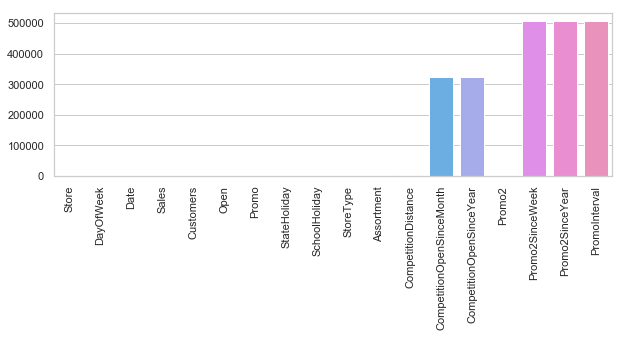

In [5]:
counts = data_train.isnull().sum()
print('Missing value counts:')
print(counts)
plt.figure(figsize=(10, 3))
g = sns.barplot(counts.index, counts.values)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

训练集 `data_train` 共包含 1017209 个数据样本。若干字段存在数据缺失情况：_CompetitionDistance_, _CompetitionOpenSinceMonth_, _CompetitionOpenSinceYear_, _Promo2SinceWeek_, _Promo2SinceYear_ 和 _PromoInterval_。其中 _CompetitionDistance_ 为连续数值变量，可通过均值补全缺失数据。由于该项目将采用 XGBoost 构建模型，默认情况下 XGBoost 支持缺失值（树算法在训练期间学习缺失值的分叉方向），可令 XGBoost 自动处理其它分类变量的缺失数据。

绘制 _Sales_、_Customers_ 和 _CompetitionDistance_ 的频率直方图和箱线图：

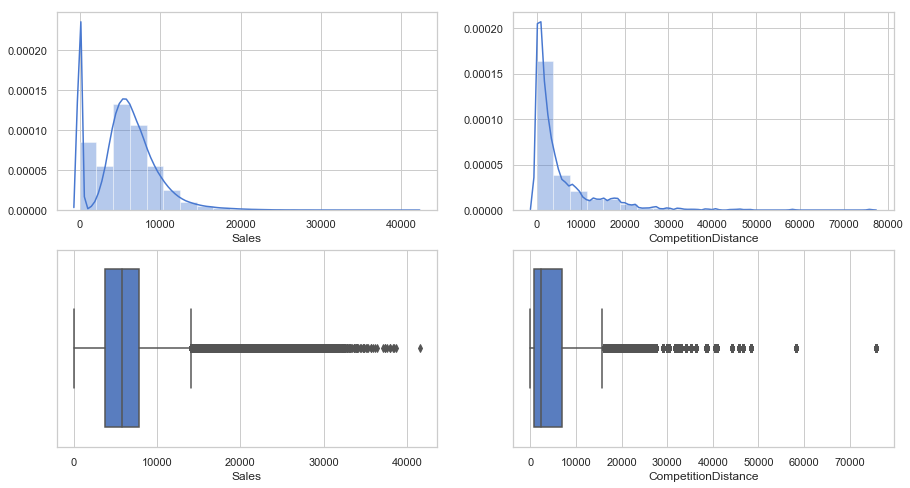

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.distplot(data_train['Sales'].dropna(), bins=20, ax=axes[0][0]);
sns.distplot(data_train['CompetitionDistance'].dropna(), bins=20, ax=axes[0][1]);
sns.boxplot(x=data_train['Sales'].dropna(), ax=axes[1][0])
sns.boxplot(x=data_train['CompetitionDistance'].dropna(), ax=axes[1][1])
plt.show()

从上图可发现在 _Sales_、_Customers_ 和 _CompetitionDistance_ 三个字段均存在异常值。 

### 可视化数据

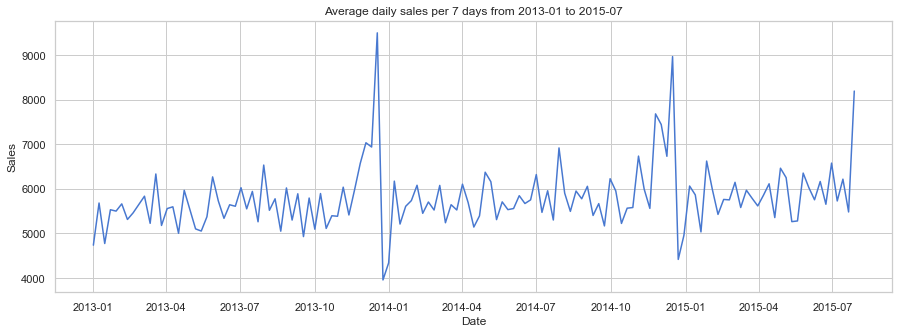

In [7]:
plt.figure(figsize=(15, 5))
data_train_sales = data_train[['Date', 'Sales']]
data_train_sales_1 = data_train_sales.groupby(pd.Grouper(key='Date', freq='7D')).mean()
ax = sns.lineplot(x=data_train_sales_1.index, y=data_train_sales_1['Sales'])
ax.set_title('Average daily sales per 7 days from 2013-01 to 2015-07')
plt.show()

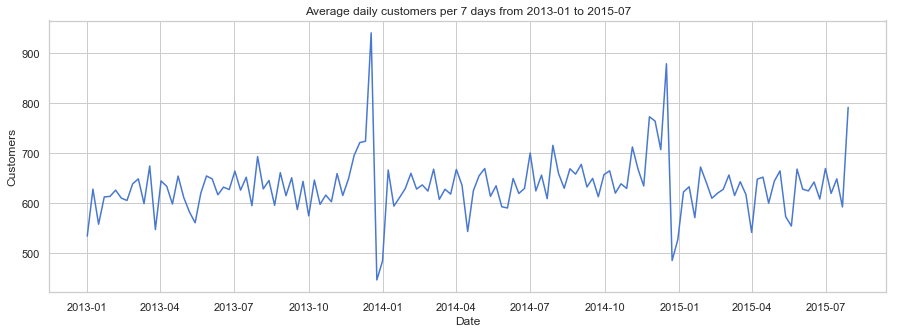

In [8]:
plt.figure(figsize=(15, 5))
data_train_customers = data_train[['Date', 'Customers']]
data_train_customers_1 = data_train_customers.groupby(pd.Grouper(key='Date', freq='7D')).mean()
ax = sns.lineplot(x=data_train_customers_1.index, y=data_train_customers_1['Customers'])
ax.set_title('Average daily customers per 7 days from 2013-01 to 2015-07')
plt.show()

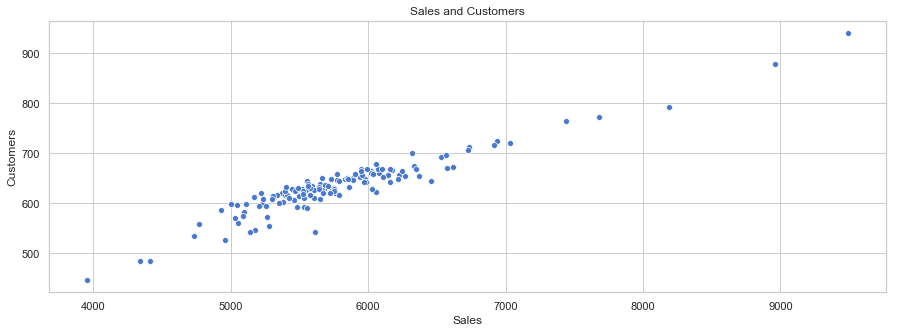

In [9]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x=data_train_sales_1['Sales'], y=data_train_customers_1['Customers']).set_title('Sales and Customers')
plt.show()

In [10]:
data_train_open_sl_cstm = data_train[['Sales', 'Customers']]
data_train_open_sl_cstm.corr()

,Sales,Customers
Sales,1.000000,0.894711
Customers,0.894711,1.000000


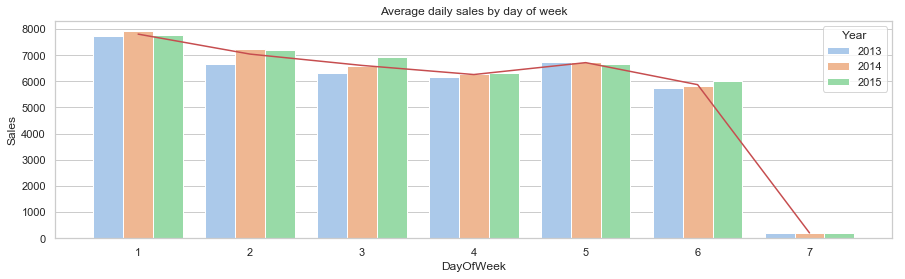

In [11]:
plt.figure(figsize=(15, 4))
data_train_wd = data_train.copy()
data_train_wd['Year'] = data_train_wd['Date'].dt.strftime('%Y')
data_train_wd = data_train_wd.groupby(['Year', 'DayOfWeek']).mean().reset_index()
sns.barplot(x='DayOfWeek', y='Sales', hue='Year', palette='pastel', data=data_train_wd)
data_train_wd = data_train_wd.groupby(['DayOfWeek']).mean().reset_index()
ax = sns.lineplot(x=data_train_wd.index, y=data_train_wd['Sales'], color='#c64d4f')
ax.set_title('Average daily sales by day of week')
ax.legend_.set_title('Year')
plt.show()

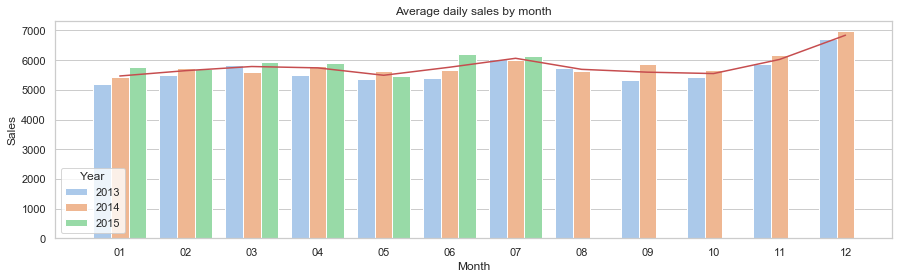

In [12]:
plt.figure(figsize=(15, 4))
data_train_m = data_train.copy()
data_train_m['Year'] = data_train_m['Date'].dt.strftime('%Y')
data_train_m['Month'] = data_train_m['Date'].dt.strftime('%m')
data_train_m = data_train_m.groupby(['Year', 'Month']).mean().reset_index()
sns.barplot(x='Month', y='Sales', hue='Year', palette='pastel', data=data_train_m)
data_train_m = data_train_m.groupby(['Month']).mean().reset_index()
ax = sns.lineplot(x=data_train_m.index, y=data_train_m['Sales'], color='#c64d4f')
ax.set_title('Average daily sales by month')
ax.legend_.set_title('Year')
plt.show()

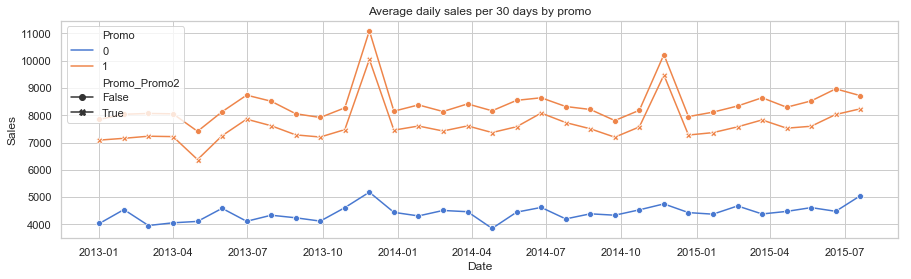

In [13]:
plt.figure(figsize=(15, 4))
data_train_ = data_train.copy()
data_train_ = data_train_[['Sales', 'Date', 'Promo', 'Promo2']]
data_train_['Promo_Promo2'] = data_train_['Promo'] & data_train_['Promo2']
data_train_ = data_train_.groupby([pd.Grouper(key='Date', freq='30D'), 'Promo', 'Promo_Promo2']).mean().reset_index()
ax = sns.lineplot(x='Date', y='Sales', hue='Promo', style='Promo_Promo2', data=data_train_, markers=True, dashes=False)
ax.set_title('Average daily sales per 30 days by promo')
plt.show()

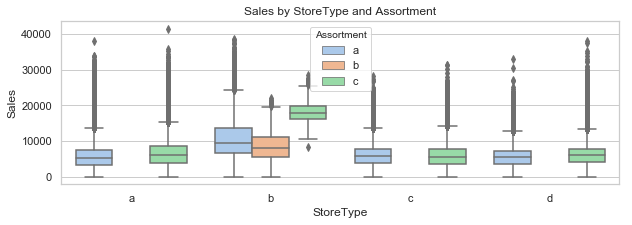

In [14]:
plt.figure(figsize=(10, 3))
ax = sns.boxplot(x='StoreType', y='Sales', hue='Assortment', palette='pastel', data=data_train)
ax.set_title('Sales by StoreType and Assortment')
plt.show()

## 数据预处理

In [1]:
from utils import preprocessing, cv, model
from sklearn.externals import joblib
import pandas as pd
import numpy as np

data_train, data_test, data_store = preprocessing.read_csv(['data/train.csv', 'data/test.csv', 'data/store.csv'])
data_train = preprocessing.combine(data_train, data_store)
X_train, y_train = preprocessing.transform(data_train, dtype='train')

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
X_train

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Year,Month,Day,DayOfYear,WeekOfYear,SchoolHolidaysThisWeek,SchoolHolidaysLastWeek,SchoolHolidaysNextWeek,CompetitionOpen,Promo2Open,InPromoMonth
0,1097,1,1,0,1,1,2,2,6.580639,3.0,2002.0,0.0,2013,1,1,1,1,6,0.0,5.0,130.0,0.00,0
1,85,1,1,0,1,1,2,1,7.534228,10.0,2011.0,0.0,2013,1,1,1,1,6,0.0,5.0,15.0,0.00,0
2,259,1,1,0,1,1,2,2,5.351858,NaN,NaN,0.0,2013,1,1,1,1,8,5.0,0.0,NaN,0.00,0
3,262,1,1,0,1,1,2,1,7.074117,5.0,2013.0,0.0,2013,1,1,1,1,6,0.0,5.0,-4.0,0.00,0
4,274,1,1,0,1,1,2,2,8.200014,NaN,NaN,1.0,2013,1,1,1,1,8,5.0,5.0,NaN,0.00,1
5,335,1,1,0,1,1,2,1,4.510860,NaN,NaN,1.0,2013,1,1,1,1,6,0.0,5.0,NaN,0.00,1
6,353,1,1,0,1,1,2,2,6.803505,NaN,NaN,1.0,2013,1,1,1,1,6,0.0,5.0,NaN,0.00,0
7,423,1,1,0,1,1,2,1,7.147559,5.0,2014.0,0.0,2013,1,1,1,1,6,0.0,5.0,-16.0,0.00,0
8,948,1,1,0,1,1,2,2,7.266129,NaN,NaN,0.0,2013,1,1,1,1,6,0.0,2.0,NaN,0.00,0
9,512,1,1,0,1,1,2,2,6.381816,NaN,NaN,1.0,2013,1,1,1,1,5,0.0,5.0,NaN,0.00,0


## 执行过程

In [4]:
params = {
    'eta': 0.03,
    'max_depth': 7,
    'min_child_weight': 2,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'silent': 1,
    'seed': 10
}

m = model.Model(params, num_boost_round=4000, early_stopping_rounds=100)
m.train(X_train, y_train)

[0]	eval-rmse:8.11018	train-rmse:8.02019	eval-rmspe:0.915145	train-rmspe:0.914443
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	eval-rmse:7.86813	train-rmse:7.78009	eval-rmspe:0.887739	train-rmspe:0.886967
[2]	eval-rmse:7.63239	train-rmse:7.54731	eval-rmspe:0.861028	train-rmspe:0.860305
[3]	eval-rmse:7.40343	train-rmse:7.32142	eval-rmspe:0.835107	train-rmspe:0.834455
[4]	eval-rmse:7.18212	train-rmse:7.10231	eval-rmspe:0.810055	train-rmspe:0.809385
[5]	eval-rmse:6.96662	train-rmse:6.88979	eval-rmspe:0.785659	train-rmspe:0.785067
[6]	eval-rmse:6.75864	train-rmse:6.68368	eval-rmspe:0.762112	train-rmspe:0.761481
[7]	eval-rmse:6.55654	train-rmse:6.48375	eval-rmspe:0.739233	train-rmspe:0.738605
[8]	eval-rmse:6.3627	train-rmse:6.28988	eval-rmspe:0.717279	train-rmspe:0.716411
[9]	eval-rmse:6.17267	train-rmse:6.10179	eval-rmspe:0.695766	train-rmspe:0.694891
[10]	eval-rmse:5.98781	train-rmse

[97]	eval-rmse:0.519679	train-rmse:0.518789	eval-rmspe:0.056927	train-rmspe:0.057271
[98]	eval-rmse:0.509383	train-rmse:0.508553	eval-rmspe:0.055791	train-rmspe:0.056133
[99]	eval-rmse:0.499456	train-rmse:0.498681	eval-rmspe:0.054699	train-rmspe:0.055039
[100]	eval-rmse:0.48958	train-rmse:0.489211	eval-rmspe:0.053613	train-rmspe:0.053992
[101]	eval-rmse:0.480043	train-rmse:0.480063	eval-rmspe:0.052569	train-rmspe:0.052983
[102]	eval-rmse:0.47119	train-rmse:0.471388	eval-rmspe:0.051602	train-rmspe:0.052028
[103]	eval-rmse:0.46251	train-rmse:0.463083	eval-rmspe:0.050655	train-rmspe:0.051116
[104]	eval-rmse:0.454236	train-rmse:0.45497	eval-rmspe:0.049754	train-rmspe:0.050225
[105]	eval-rmse:0.445977	train-rmse:0.446802	eval-rmspe:0.048856	train-rmspe:0.049331
[106]	eval-rmse:0.437807	train-rmse:0.439212	eval-rmspe:0.047971	train-rmspe:0.048503
[107]	eval-rmse:0.429873	train-rmse:0.432213	eval-rmspe:0.047115	train-rmspe:0.047742
[108]	eval-rmse:0.422699	train-rmse:0.425218	eval-rmspe:0.046

[193]	eval-rmse:0.265305	train-rmse:0.270247	eval-rmspe:0.030394	train-rmspe:0.031277
[194]	eval-rmse:0.264722	train-rmse:0.269648	eval-rmspe:0.030334	train-rmspe:0.031216
[195]	eval-rmse:0.264608	train-rmse:0.269532	eval-rmspe:0.030328	train-rmspe:0.031209
[196]	eval-rmse:0.26434	train-rmse:0.269236	eval-rmspe:0.030302	train-rmspe:0.03118
[197]	eval-rmse:0.264067	train-rmse:0.268926	eval-rmspe:0.030276	train-rmspe:0.03115
[198]	eval-rmse:0.263913	train-rmse:0.268786	eval-rmspe:0.030265	train-rmspe:0.03114
[199]	eval-rmse:0.263518	train-rmse:0.268371	eval-rmspe:0.030223	train-rmspe:0.031097
[200]	eval-rmse:0.26328	train-rmse:0.268186	eval-rmspe:0.030195	train-rmspe:0.03108
[201]	eval-rmse:0.262924	train-rmse:0.267808	eval-rmspe:0.03016	train-rmspe:0.031044
[202]	eval-rmse:0.262787	train-rmse:0.267685	eval-rmspe:0.030149	train-rmspe:0.031035
[203]	eval-rmse:0.262607	train-rmse:0.267546	eval-rmspe:0.030136	train-rmspe:0.031024
[204]	eval-rmse:0.262326	train-rmse:0.267363	eval-rmspe:0.030

[289]	eval-rmse:0.235495	train-rmse:0.239082	eval-rmspe:0.027132	train-rmspe:0.027894
[290]	eval-rmse:0.235342	train-rmse:0.238902	eval-rmspe:0.027115	train-rmspe:0.027873
[291]	eval-rmse:0.23485	train-rmse:0.23833	eval-rmspe:0.027062	train-rmspe:0.027811
[292]	eval-rmse:0.233727	train-rmse:0.237199	eval-rmspe:0.026935	train-rmspe:0.027682
[293]	eval-rmse:0.233587	train-rmse:0.237049	eval-rmspe:0.026919	train-rmspe:0.027665
[294]	eval-rmse:0.233513	train-rmse:0.236986	eval-rmspe:0.026912	train-rmspe:0.027658
[295]	eval-rmse:0.233319	train-rmse:0.236747	eval-rmspe:0.026891	train-rmspe:0.027631
[296]	eval-rmse:0.233131	train-rmse:0.236643	eval-rmspe:0.026867	train-rmspe:0.027618
[297]	eval-rmse:0.232629	train-rmse:0.236081	eval-rmspe:0.02681	train-rmspe:0.027554
[298]	eval-rmse:0.232059	train-rmse:0.23558	eval-rmspe:0.026746	train-rmspe:0.027499
[299]	eval-rmse:0.231642	train-rmse:0.23517	eval-rmspe:0.026698	train-rmspe:0.027452
[300]	eval-rmse:0.231551	train-rmse:0.235092	eval-rmspe:0.0

[385]	eval-rmse:0.214323	train-rmse:0.217215	eval-rmspe:0.024702	train-rmspe:0.025396
[386]	eval-rmse:0.214069	train-rmse:0.216952	eval-rmspe:0.024672	train-rmspe:0.025366
[387]	eval-rmse:0.213767	train-rmse:0.216647	eval-rmspe:0.024637	train-rmspe:0.025331
[388]	eval-rmse:0.213332	train-rmse:0.216317	eval-rmspe:0.024592	train-rmspe:0.025294
[389]	eval-rmse:0.213281	train-rmse:0.216263	eval-rmspe:0.024586	train-rmspe:0.025287
[390]	eval-rmse:0.213075	train-rmse:0.2161	eval-rmspe:0.024565	train-rmspe:0.025269
[391]	eval-rmse:0.212659	train-rmse:0.21566	eval-rmspe:0.024517	train-rmspe:0.025219
[392]	eval-rmse:0.212542	train-rmse:0.21554	eval-rmspe:0.024505	train-rmspe:0.025206
[393]	eval-rmse:0.212403	train-rmse:0.215331	eval-rmspe:0.024488	train-rmspe:0.025182
[394]	eval-rmse:0.212031	train-rmse:0.214945	eval-rmspe:0.024444	train-rmspe:0.025138
[395]	eval-rmse:0.211986	train-rmse:0.214913	eval-rmspe:0.024441	train-rmspe:0.025134
[396]	eval-rmse:0.211849	train-rmse:0.214761	eval-rmspe:0.

[481]	eval-rmse:0.19563	train-rmse:0.197653	eval-rmspe:0.022571	train-rmspe:0.023157
[482]	eval-rmse:0.195479	train-rmse:0.197476	eval-rmspe:0.022554	train-rmspe:0.023136
[483]	eval-rmse:0.195416	train-rmse:0.197393	eval-rmspe:0.022546	train-rmspe:0.023126
[484]	eval-rmse:0.195164	train-rmse:0.197133	eval-rmspe:0.022518	train-rmspe:0.023097
[485]	eval-rmse:0.194972	train-rmse:0.196895	eval-rmspe:0.022495	train-rmspe:0.023069
[486]	eval-rmse:0.194778	train-rmse:0.196659	eval-rmspe:0.022473	train-rmspe:0.023042
[487]	eval-rmse:0.19462	train-rmse:0.196508	eval-rmspe:0.022457	train-rmspe:0.023023
[488]	eval-rmse:0.194586	train-rmse:0.196485	eval-rmspe:0.022453	train-rmspe:0.023021
[489]	eval-rmse:0.194344	train-rmse:0.19621	eval-rmspe:0.022426	train-rmspe:0.02299
[490]	eval-rmse:0.194075	train-rmse:0.195888	eval-rmspe:0.022395	train-rmspe:0.022953
[491]	eval-rmse:0.193768	train-rmse:0.195585	eval-rmspe:0.022359	train-rmspe:0.022918
[492]	eval-rmse:0.193674	train-rmse:0.195484	eval-rmspe:0.

[577]	eval-rmse:0.180963	train-rmse:0.181853	eval-rmspe:0.020886	train-rmspe:0.021335
[578]	eval-rmse:0.181027	train-rmse:0.181794	eval-rmspe:0.020902	train-rmspe:0.021329
[579]	eval-rmse:0.180764	train-rmse:0.181523	eval-rmspe:0.020872	train-rmspe:0.021297
[580]	eval-rmse:0.180778	train-rmse:0.18146	eval-rmspe:0.020873	train-rmspe:0.021289
[581]	eval-rmse:0.180719	train-rmse:0.181402	eval-rmspe:0.020866	train-rmspe:0.021283
[582]	eval-rmse:0.180676	train-rmse:0.181336	eval-rmspe:0.020861	train-rmspe:0.021275
[583]	eval-rmse:0.180541	train-rmse:0.181209	eval-rmspe:0.020845	train-rmspe:0.02126
[584]	eval-rmse:0.180456	train-rmse:0.181094	eval-rmspe:0.020835	train-rmspe:0.021247
[585]	eval-rmse:0.180472	train-rmse:0.181032	eval-rmspe:0.020836	train-rmspe:0.02124
[586]	eval-rmse:0.180322	train-rmse:0.180856	eval-rmspe:0.020819	train-rmspe:0.02122
[587]	eval-rmse:0.180339	train-rmse:0.180818	eval-rmspe:0.020822	train-rmspe:0.021216
[588]	eval-rmse:0.180257	train-rmse:0.180686	eval-rmspe:0.

[673]	eval-rmse:0.170306	train-rmse:0.170113	eval-rmspe:0.019665	train-rmspe:0.019974
[674]	eval-rmse:0.170142	train-rmse:0.169952	eval-rmspe:0.019646	train-rmspe:0.019955
[675]	eval-rmse:0.170069	train-rmse:0.169881	eval-rmspe:0.019638	train-rmspe:0.019947
[676]	eval-rmse:0.169794	train-rmse:0.169605	eval-rmspe:0.019607	train-rmspe:0.019916
[677]	eval-rmse:0.169736	train-rmse:0.16954	eval-rmspe:0.0196	train-rmspe:0.019908
[678]	eval-rmse:0.169717	train-rmse:0.169504	eval-rmspe:0.019598	train-rmspe:0.019904
[679]	eval-rmse:0.169499	train-rmse:0.169264	eval-rmspe:0.019572	train-rmspe:0.019876
[680]	eval-rmse:0.169322	train-rmse:0.169064	eval-rmspe:0.019552	train-rmspe:0.019853
[681]	eval-rmse:0.169311	train-rmse:0.169044	eval-rmspe:0.019551	train-rmspe:0.019851
[682]	eval-rmse:0.169241	train-rmse:0.168998	eval-rmspe:0.019543	train-rmspe:0.019846
[683]	eval-rmse:0.169142	train-rmse:0.168927	eval-rmspe:0.019532	train-rmspe:0.019838
[684]	eval-rmse:0.168974	train-rmse:0.168757	eval-rmspe:0

[769]	eval-rmse:0.160275	train-rmse:0.158911	eval-rmspe:0.01852	train-rmspe:0.018683
[770]	eval-rmse:0.160205	train-rmse:0.158812	eval-rmspe:0.018512	train-rmspe:0.018672
[771]	eval-rmse:0.160104	train-rmse:0.158769	eval-rmspe:0.0185	train-rmspe:0.018667
[772]	eval-rmse:0.16009	train-rmse:0.158738	eval-rmspe:0.018498	train-rmspe:0.018663
[773]	eval-rmse:0.159974	train-rmse:0.158608	eval-rmspe:0.018485	train-rmspe:0.018648
[774]	eval-rmse:0.159885	train-rmse:0.158476	eval-rmspe:0.018474	train-rmspe:0.018633
[775]	eval-rmse:0.159749	train-rmse:0.15828	eval-rmspe:0.018459	train-rmspe:0.01861
[776]	eval-rmse:0.159574	train-rmse:0.158089	eval-rmspe:0.018438	train-rmspe:0.018588
[777]	eval-rmse:0.159421	train-rmse:0.157922	eval-rmspe:0.018421	train-rmspe:0.018569
[778]	eval-rmse:0.159367	train-rmse:0.157861	eval-rmspe:0.018415	train-rmspe:0.018562
[779]	eval-rmse:0.159206	train-rmse:0.157701	eval-rmspe:0.018396	train-rmspe:0.018543
[780]	eval-rmse:0.159126	train-rmse:0.157616	eval-rmspe:0.01

[865]	eval-rmse:0.151995	train-rmse:0.149587	eval-rmspe:0.017557	train-rmspe:0.017606
[866]	eval-rmse:0.151894	train-rmse:0.149469	eval-rmspe:0.017546	train-rmspe:0.017592
[867]	eval-rmse:0.151791	train-rmse:0.149352	eval-rmspe:0.017534	train-rmspe:0.017579
[868]	eval-rmse:0.151728	train-rmse:0.149314	eval-rmspe:0.017526	train-rmspe:0.017575
[869]	eval-rmse:0.15165	train-rmse:0.149278	eval-rmspe:0.017517	train-rmspe:0.017571
[870]	eval-rmse:0.151591	train-rmse:0.149213	eval-rmspe:0.01751	train-rmspe:0.017563
[871]	eval-rmse:0.151479	train-rmse:0.149079	eval-rmspe:0.017498	train-rmspe:0.017547
[872]	eval-rmse:0.151392	train-rmse:0.148982	eval-rmspe:0.017488	train-rmspe:0.017536
[873]	eval-rmse:0.151388	train-rmse:0.148965	eval-rmspe:0.017487	train-rmspe:0.017534
[874]	eval-rmse:0.151345	train-rmse:0.148913	eval-rmspe:0.017482	train-rmspe:0.017528
[875]	eval-rmse:0.151307	train-rmse:0.148843	eval-rmspe:0.017478	train-rmspe:0.01752
[876]	eval-rmse:0.151218	train-rmse:0.148752	eval-rmspe:0

[961]	eval-rmse:0.145999	train-rmse:0.143159	eval-rmspe:0.016868	train-rmspe:0.016862
[962]	eval-rmse:0.145934	train-rmse:0.143077	eval-rmspe:0.016861	train-rmspe:0.016853
[963]	eval-rmse:0.145881	train-rmse:0.143015	eval-rmspe:0.016855	train-rmspe:0.016845
[964]	eval-rmse:0.145862	train-rmse:0.142978	eval-rmspe:0.016852	train-rmspe:0.016841
[965]	eval-rmse:0.145779	train-rmse:0.142874	eval-rmspe:0.016842	train-rmspe:0.016829
[966]	eval-rmse:0.145699	train-rmse:0.142813	eval-rmspe:0.016833	train-rmspe:0.016822
[967]	eval-rmse:0.145638	train-rmse:0.142752	eval-rmspe:0.016825	train-rmspe:0.016815
[968]	eval-rmse:0.145615	train-rmse:0.142714	eval-rmspe:0.016823	train-rmspe:0.016811
[969]	eval-rmse:0.145547	train-rmse:0.142643	eval-rmspe:0.016816	train-rmspe:0.016803
[970]	eval-rmse:0.145493	train-rmse:0.142575	eval-rmspe:0.016809	train-rmspe:0.016795
[971]	eval-rmse:0.145499	train-rmse:0.142549	eval-rmspe:0.01681	train-rmspe:0.016792
[972]	eval-rmse:0.145445	train-rmse:0.142478	eval-rmspe

[1057]	eval-rmse:0.141388	train-rmse:0.138005	eval-rmspe:0.016336	train-rmspe:0.016266
[1058]	eval-rmse:0.141357	train-rmse:0.137965	eval-rmspe:0.016332	train-rmspe:0.016261
[1059]	eval-rmse:0.141251	train-rmse:0.137883	eval-rmspe:0.01632	train-rmspe:0.016251
[1060]	eval-rmse:0.141174	train-rmse:0.137773	eval-rmspe:0.016311	train-rmspe:0.016238
[1061]	eval-rmse:0.141144	train-rmse:0.137752	eval-rmspe:0.016308	train-rmspe:0.016235
[1062]	eval-rmse:0.141033	train-rmse:0.137621	eval-rmspe:0.016296	train-rmspe:0.016221
[1063]	eval-rmse:0.141025	train-rmse:0.137612	eval-rmspe:0.016295	train-rmspe:0.016219
[1064]	eval-rmse:0.140937	train-rmse:0.137468	eval-rmspe:0.016285	train-rmspe:0.016202
[1065]	eval-rmse:0.140837	train-rmse:0.137319	eval-rmspe:0.016273	train-rmspe:0.016185
[1066]	eval-rmse:0.140766	train-rmse:0.137284	eval-rmspe:0.016264	train-rmspe:0.016181
[1067]	eval-rmse:0.140698	train-rmse:0.137211	eval-rmspe:0.016256	train-rmspe:0.016172
[1068]	eval-rmse:0.140693	train-rmse:0.13720

[1152]	eval-rmse:0.137488	train-rmse:0.133413	eval-rmspe:0.015889	train-rmspe:0.01573
[1153]	eval-rmse:0.137429	train-rmse:0.133344	eval-rmspe:0.015882	train-rmspe:0.015722
[1154]	eval-rmse:0.137373	train-rmse:0.133273	eval-rmspe:0.015876	train-rmspe:0.015713
[1155]	eval-rmse:0.137329	train-rmse:0.133222	eval-rmspe:0.015871	train-rmspe:0.015707
[1156]	eval-rmse:0.137308	train-rmse:0.133205	eval-rmspe:0.015868	train-rmspe:0.015705
[1157]	eval-rmse:0.137273	train-rmse:0.133181	eval-rmspe:0.015864	train-rmspe:0.015702
[1158]	eval-rmse:0.137269	train-rmse:0.133166	eval-rmspe:0.015864	train-rmspe:0.015701
[1159]	eval-rmse:0.137242	train-rmse:0.133153	eval-rmspe:0.01586	train-rmspe:0.015699
[1160]	eval-rmse:0.137237	train-rmse:0.133116	eval-rmspe:0.01586	train-rmspe:0.015695
[1161]	eval-rmse:0.137228	train-rmse:0.133099	eval-rmspe:0.015859	train-rmspe:0.015693
[1162]	eval-rmse:0.137225	train-rmse:0.133092	eval-rmspe:0.015858	train-rmspe:0.015692
[1163]	eval-rmse:0.137184	train-rmse:0.133042	

[1247]	eval-rmse:0.134151	train-rmse:0.129674	eval-rmspe:0.015515	train-rmspe:0.015292
[1248]	eval-rmse:0.134093	train-rmse:0.129614	eval-rmspe:0.015508	train-rmspe:0.015285
[1249]	eval-rmse:0.134087	train-rmse:0.12961	eval-rmspe:0.015508	train-rmspe:0.015285
[1250]	eval-rmse:0.134048	train-rmse:0.129585	eval-rmspe:0.015503	train-rmspe:0.015282
[1251]	eval-rmse:0.134004	train-rmse:0.12952	eval-rmspe:0.015498	train-rmspe:0.015274
[1252]	eval-rmse:0.133966	train-rmse:0.129477	eval-rmspe:0.015494	train-rmspe:0.015269
[1253]	eval-rmse:0.133945	train-rmse:0.129459	eval-rmspe:0.015491	train-rmspe:0.015268
[1254]	eval-rmse:0.133909	train-rmse:0.129413	eval-rmspe:0.015487	train-rmspe:0.015262
[1255]	eval-rmse:0.133909	train-rmse:0.12939	eval-rmspe:0.015487	train-rmspe:0.015259
[1256]	eval-rmse:0.133876	train-rmse:0.12935	eval-rmspe:0.015483	train-rmspe:0.015255
[1257]	eval-rmse:0.133813	train-rmse:0.129276	eval-rmspe:0.015475	train-rmspe:0.015246
[1258]	eval-rmse:0.133807	train-rmse:0.129264	e

[1342]	eval-rmse:0.131631	train-rmse:0.126401	eval-rmspe:0.015222	train-rmspe:0.014912
[1343]	eval-rmse:0.131593	train-rmse:0.126355	eval-rmspe:0.015218	train-rmspe:0.014906
[1344]	eval-rmse:0.131592	train-rmse:0.126332	eval-rmspe:0.015217	train-rmspe:0.014904
[1345]	eval-rmse:0.131548	train-rmse:0.126297	eval-rmspe:0.015212	train-rmspe:0.0149
[1346]	eval-rmse:0.131537	train-rmse:0.126293	eval-rmspe:0.015211	train-rmspe:0.014899
[1347]	eval-rmse:0.131522	train-rmse:0.126268	eval-rmspe:0.015209	train-rmspe:0.014896
[1348]	eval-rmse:0.131448	train-rmse:0.126169	eval-rmspe:0.015201	train-rmspe:0.014885
[1349]	eval-rmse:0.13144	train-rmse:0.126167	eval-rmspe:0.0152	train-rmspe:0.014885
[1350]	eval-rmse:0.131419	train-rmse:0.126145	eval-rmspe:0.015197	train-rmspe:0.014882
[1351]	eval-rmse:0.13141	train-rmse:0.126138	eval-rmspe:0.015196	train-rmspe:0.014881
[1352]	eval-rmse:0.131379	train-rmse:0.126101	eval-rmspe:0.015192	train-rmspe:0.014877
[1353]	eval-rmse:0.131337	train-rmse:0.126058	eva

[1437]	eval-rmse:0.128815	train-rmse:0.123284	eval-rmspe:0.014896	train-rmspe:0.014549
[1438]	eval-rmse:0.128799	train-rmse:0.123262	eval-rmspe:0.014894	train-rmspe:0.014546
[1439]	eval-rmse:0.128779	train-rmse:0.123246	eval-rmspe:0.014892	train-rmspe:0.014544
[1440]	eval-rmse:0.128752	train-rmse:0.123212	eval-rmspe:0.014889	train-rmspe:0.01454
[1441]	eval-rmse:0.128748	train-rmse:0.123205	eval-rmspe:0.014888	train-rmspe:0.014539
[1442]	eval-rmse:0.12871	train-rmse:0.123162	eval-rmspe:0.014884	train-rmspe:0.014535
[1443]	eval-rmse:0.128702	train-rmse:0.123152	eval-rmspe:0.014883	train-rmspe:0.014534
[1444]	eval-rmse:0.128665	train-rmse:0.123118	eval-rmspe:0.014879	train-rmspe:0.01453
[1445]	eval-rmse:0.128645	train-rmse:0.123102	eval-rmspe:0.014877	train-rmspe:0.014528
[1446]	eval-rmse:0.128598	train-rmse:0.123059	eval-rmspe:0.014871	train-rmspe:0.014523
[1447]	eval-rmse:0.128563	train-rmse:0.12303	eval-rmspe:0.014867	train-rmspe:0.01452
[1448]	eval-rmse:0.128521	train-rmse:0.122991	ev

[1532]	eval-rmse:0.126584	train-rmse:0.120774	eval-rmspe:0.01464	train-rmspe:0.014258
[1533]	eval-rmse:0.126561	train-rmse:0.12075	eval-rmspe:0.014638	train-rmspe:0.014255
[1534]	eval-rmse:0.126512	train-rmse:0.120662	eval-rmspe:0.014632	train-rmspe:0.014245
[1535]	eval-rmse:0.126504	train-rmse:0.120642	eval-rmspe:0.014631	train-rmspe:0.014242
[1536]	eval-rmse:0.126486	train-rmse:0.120623	eval-rmspe:0.014628	train-rmspe:0.01424
[1537]	eval-rmse:0.126476	train-rmse:0.120607	eval-rmspe:0.014627	train-rmspe:0.014238
[1538]	eval-rmse:0.12644	train-rmse:0.120559	eval-rmspe:0.014623	train-rmspe:0.014233
[1539]	eval-rmse:0.126428	train-rmse:0.120544	eval-rmspe:0.014622	train-rmspe:0.014231
[1540]	eval-rmse:0.126394	train-rmse:0.120504	eval-rmspe:0.014618	train-rmspe:0.014226
[1541]	eval-rmse:0.126359	train-rmse:0.120472	eval-rmspe:0.014614	train-rmspe:0.014222
[1542]	eval-rmse:0.126348	train-rmse:0.120458	eval-rmspe:0.014612	train-rmspe:0.014221
[1543]	eval-rmse:0.126283	train-rmse:0.120397	e

[1627]	eval-rmse:0.124367	train-rmse:0.117917	eval-rmspe:0.01438	train-rmspe:0.013923
[1628]	eval-rmse:0.124344	train-rmse:0.117891	eval-rmspe:0.014377	train-rmspe:0.01392
[1629]	eval-rmse:0.124339	train-rmse:0.117888	eval-rmspe:0.014377	train-rmspe:0.01392
[1630]	eval-rmse:0.124339	train-rmse:0.117875	eval-rmspe:0.014377	train-rmspe:0.013918
[1631]	eval-rmse:0.124337	train-rmse:0.117872	eval-rmspe:0.014376	train-rmspe:0.013918
[1632]	eval-rmse:0.124322	train-rmse:0.117851	eval-rmspe:0.014375	train-rmspe:0.013915
[1633]	eval-rmse:0.124261	train-rmse:0.117825	eval-rmspe:0.014366	train-rmspe:0.013913
[1634]	eval-rmse:0.124237	train-rmse:0.117802	eval-rmspe:0.014363	train-rmspe:0.01391
[1635]	eval-rmse:0.124237	train-rmse:0.117796	eval-rmspe:0.014363	train-rmspe:0.013909
[1636]	eval-rmse:0.124233	train-rmse:0.117774	eval-rmspe:0.014362	train-rmspe:0.013907
[1637]	eval-rmse:0.124225	train-rmse:0.117767	eval-rmspe:0.014361	train-rmspe:0.013906
[1638]	eval-rmse:0.124198	train-rmse:0.117748	e

[1722]	eval-rmse:0.122698	train-rmse:0.115826	eval-rmspe:0.014183	train-rmspe:0.013679
[1723]	eval-rmse:0.12269	train-rmse:0.115818	eval-rmspe:0.014182	train-rmspe:0.013678
[1724]	eval-rmse:0.122668	train-rmse:0.115796	eval-rmspe:0.014179	train-rmspe:0.013675
[1725]	eval-rmse:0.122662	train-rmse:0.115789	eval-rmspe:0.014179	train-rmspe:0.013674
[1726]	eval-rmse:0.122652	train-rmse:0.115772	eval-rmspe:0.014178	train-rmspe:0.013672
[1727]	eval-rmse:0.122775	train-rmse:0.115763	eval-rmspe:0.014198	train-rmspe:0.013671
[1728]	eval-rmse:0.122737	train-rmse:0.11573	eval-rmspe:0.014194	train-rmspe:0.013667
[1729]	eval-rmse:0.122728	train-rmse:0.115709	eval-rmspe:0.014192	train-rmspe:0.013665
[1730]	eval-rmse:0.122711	train-rmse:0.115692	eval-rmspe:0.014191	train-rmspe:0.013663
[1731]	eval-rmse:0.122694	train-rmse:0.115665	eval-rmspe:0.014189	train-rmspe:0.01366
[1732]	eval-rmse:0.122677	train-rmse:0.115647	eval-rmspe:0.014187	train-rmspe:0.013658
[1733]	eval-rmse:0.122658	train-rmse:0.115622	

[1817]	eval-rmse:0.121465	train-rmse:0.114019	eval-rmspe:0.014052	train-rmspe:0.013466
[1818]	eval-rmse:0.121465	train-rmse:0.114008	eval-rmspe:0.014052	train-rmspe:0.013464
[1819]	eval-rmse:0.121453	train-rmse:0.113991	eval-rmspe:0.01405	train-rmspe:0.013462
[1820]	eval-rmse:0.121428	train-rmse:0.11396	eval-rmspe:0.014047	train-rmspe:0.013459
[1821]	eval-rmse:0.121401	train-rmse:0.113931	eval-rmspe:0.014044	train-rmspe:0.013455
[1822]	eval-rmse:0.121374	train-rmse:0.113903	eval-rmspe:0.01404	train-rmspe:0.013452
[1823]	eval-rmse:0.121351	train-rmse:0.113887	eval-rmspe:0.014038	train-rmspe:0.01345
[1824]	eval-rmse:0.121335	train-rmse:0.113864	eval-rmspe:0.014036	train-rmspe:0.013448
[1825]	eval-rmse:0.121314	train-rmse:0.113844	eval-rmspe:0.014033	train-rmspe:0.013445
[1826]	eval-rmse:0.121298	train-rmse:0.113826	eval-rmspe:0.014032	train-rmspe:0.013443
[1827]	eval-rmse:0.121297	train-rmse:0.11382	eval-rmspe:0.014031	train-rmspe:0.013443
[1828]	eval-rmse:0.121295	train-rmse:0.113812	ev

[1912]	eval-rmse:0.120059	train-rmse:0.112118	eval-rmspe:0.013886	train-rmspe:0.013244
[1913]	eval-rmse:0.120037	train-rmse:0.112091	eval-rmspe:0.013883	train-rmspe:0.013241
[1914]	eval-rmse:0.120027	train-rmse:0.11208	eval-rmspe:0.013882	train-rmspe:0.013239
[1915]	eval-rmse:0.12002	train-rmse:0.112067	eval-rmspe:0.013881	train-rmspe:0.013238
[1916]	eval-rmse:0.120009	train-rmse:0.112046	eval-rmspe:0.01388	train-rmspe:0.013235
[1917]	eval-rmse:0.120009	train-rmse:0.112033	eval-rmspe:0.01388	train-rmspe:0.013234
[1918]	eval-rmse:0.120009	train-rmse:0.11203	eval-rmspe:0.01388	train-rmspe:0.013234
[1919]	eval-rmse:0.120019	train-rmse:0.112021	eval-rmspe:0.013882	train-rmspe:0.013233
[1920]	eval-rmse:0.120004	train-rmse:0.11199	eval-rmspe:0.01388	train-rmspe:0.013229
[1921]	eval-rmse:0.119996	train-rmse:0.111972	eval-rmspe:0.013879	train-rmspe:0.013227
[1922]	eval-rmse:0.119988	train-rmse:0.11196	eval-rmspe:0.013878	train-rmspe:0.013225
[1923]	eval-rmse:0.119981	train-rmse:0.11195	eval-rm

[2007]	eval-rmse:0.119328	train-rmse:0.110668	eval-rmspe:0.013803	train-rmspe:0.013073
[2008]	eval-rmse:0.119325	train-rmse:0.11065	eval-rmspe:0.013803	train-rmspe:0.013071
[2009]	eval-rmse:0.119325	train-rmse:0.110633	eval-rmspe:0.013803	train-rmspe:0.013069
[2010]	eval-rmse:0.119312	train-rmse:0.11061	eval-rmspe:0.013801	train-rmspe:0.013066
[2011]	eval-rmse:0.119283	train-rmse:0.110588	eval-rmspe:0.013798	train-rmspe:0.013063
[2012]	eval-rmse:0.119281	train-rmse:0.11058	eval-rmspe:0.013798	train-rmspe:0.013062
[2013]	eval-rmse:0.119283	train-rmse:0.110575	eval-rmspe:0.013798	train-rmspe:0.013062
[2014]	eval-rmse:0.119271	train-rmse:0.110557	eval-rmspe:0.013797	train-rmspe:0.01306
[2015]	eval-rmse:0.119265	train-rmse:0.110549	eval-rmspe:0.013796	train-rmspe:0.013059
[2016]	eval-rmse:0.119262	train-rmse:0.110545	eval-rmspe:0.013796	train-rmspe:0.013058
[2017]	eval-rmse:0.119243	train-rmse:0.110529	eval-rmspe:0.013793	train-rmspe:0.013057
[2018]	eval-rmse:0.119228	train-rmse:0.110516	e

[2102]	eval-rmse:0.118233	train-rmse:0.109216	eval-rmspe:0.013676	train-rmspe:0.012903
[2103]	eval-rmse:0.118224	train-rmse:0.109197	eval-rmspe:0.013675	train-rmspe:0.012901
[2104]	eval-rmse:0.118203	train-rmse:0.109177	eval-rmspe:0.013673	train-rmspe:0.012898
[2105]	eval-rmse:0.118205	train-rmse:0.109169	eval-rmspe:0.013673	train-rmspe:0.012897
[2106]	eval-rmse:0.118203	train-rmse:0.109164	eval-rmspe:0.013673	train-rmspe:0.012897
[2107]	eval-rmse:0.118203	train-rmse:0.109159	eval-rmspe:0.013673	train-rmspe:0.012896
[2108]	eval-rmse:0.118124	train-rmse:0.109143	eval-rmspe:0.013663	train-rmspe:0.012894
[2109]	eval-rmse:0.118125	train-rmse:0.109137	eval-rmspe:0.013663	train-rmspe:0.012894
[2110]	eval-rmse:0.118094	train-rmse:0.109099	eval-rmspe:0.01366	train-rmspe:0.012889
[2111]	eval-rmse:0.118085	train-rmse:0.109088	eval-rmspe:0.013658	train-rmspe:0.012888
[2112]	eval-rmse:0.118037	train-rmse:0.10904	eval-rmspe:0.013653	train-rmspe:0.012882
[2113]	eval-rmse:0.118038	train-rmse:0.109034

[2197]	eval-rmse:0.11705	train-rmse:0.107775	eval-rmspe:0.013537	train-rmspe:0.012734
[2198]	eval-rmse:0.117035	train-rmse:0.107756	eval-rmspe:0.013535	train-rmspe:0.012732
[2199]	eval-rmse:0.117032	train-rmse:0.10775	eval-rmspe:0.013534	train-rmspe:0.012731
[2200]	eval-rmse:0.117019	train-rmse:0.107727	eval-rmspe:0.013533	train-rmspe:0.012728
[2201]	eval-rmse:0.116996	train-rmse:0.107713	eval-rmspe:0.01353	train-rmspe:0.012727
[2202]	eval-rmse:0.116998	train-rmse:0.107709	eval-rmspe:0.01353	train-rmspe:0.012726
[2203]	eval-rmse:0.116997	train-rmse:0.107705	eval-rmspe:0.01353	train-rmspe:0.012725
[2204]	eval-rmse:0.116986	train-rmse:0.107695	eval-rmspe:0.013529	train-rmspe:0.012724
[2205]	eval-rmse:0.116984	train-rmse:0.107692	eval-rmspe:0.013528	train-rmspe:0.012724
[2206]	eval-rmse:0.116983	train-rmse:0.107683	eval-rmspe:0.013528	train-rmspe:0.012723
[2207]	eval-rmse:0.116966	train-rmse:0.107661	eval-rmspe:0.013526	train-rmspe:0.01272
[2208]	eval-rmse:0.116953	train-rmse:0.107644	eva

[2292]	eval-rmse:0.116294	train-rmse:0.106584	eval-rmspe:0.013447	train-rmspe:0.012594
[2293]	eval-rmse:0.116286	train-rmse:0.106572	eval-rmspe:0.013446	train-rmspe:0.012592
[2294]	eval-rmse:0.116275	train-rmse:0.106554	eval-rmspe:0.013444	train-rmspe:0.01259
[2295]	eval-rmse:0.116263	train-rmse:0.106533	eval-rmspe:0.013443	train-rmspe:0.012588
[2296]	eval-rmse:0.116261	train-rmse:0.106525	eval-rmspe:0.013443	train-rmspe:0.012587
[2297]	eval-rmse:0.116245	train-rmse:0.106513	eval-rmspe:0.013441	train-rmspe:0.012586
[2298]	eval-rmse:0.116242	train-rmse:0.106508	eval-rmspe:0.013441	train-rmspe:0.012585
[2299]	eval-rmse:0.116243	train-rmse:0.106483	eval-rmspe:0.013441	train-rmspe:0.012582
[2300]	eval-rmse:0.116218	train-rmse:0.106461	eval-rmspe:0.013438	train-rmspe:0.01258
[2301]	eval-rmse:0.116212	train-rmse:0.106443	eval-rmspe:0.013437	train-rmspe:0.012577
[2302]	eval-rmse:0.116211	train-rmse:0.106439	eval-rmspe:0.013437	train-rmspe:0.012577
[2303]	eval-rmse:0.116196	train-rmse:0.10642	

[2387]	eval-rmse:0.115677	train-rmse:0.105433	eval-rmspe:0.013383	train-rmspe:0.012459
[2388]	eval-rmse:0.115677	train-rmse:0.105426	eval-rmspe:0.013383	train-rmspe:0.012459
[2389]	eval-rmse:0.115654	train-rmse:0.105415	eval-rmspe:0.01338	train-rmspe:0.012457
[2390]	eval-rmse:0.115652	train-rmse:0.105413	eval-rmspe:0.01338	train-rmspe:0.012457
[2391]	eval-rmse:0.115629	train-rmse:0.105389	eval-rmspe:0.013377	train-rmspe:0.012454
[2392]	eval-rmse:0.11562	train-rmse:0.105373	eval-rmspe:0.013376	train-rmspe:0.012452
[2393]	eval-rmse:0.115621	train-rmse:0.105363	eval-rmspe:0.013376	train-rmspe:0.012451
[2394]	eval-rmse:0.11562	train-rmse:0.10536	eval-rmspe:0.013376	train-rmspe:0.012451
[2395]	eval-rmse:0.115605	train-rmse:0.105344	eval-rmspe:0.013374	train-rmspe:0.012449
[2396]	eval-rmse:0.115598	train-rmse:0.105338	eval-rmspe:0.013373	train-rmspe:0.012448
[2397]	eval-rmse:0.115579	train-rmse:0.105318	eval-rmspe:0.013371	train-rmspe:0.012446
[2398]	eval-rmse:0.115577	train-rmse:0.105302	ev

[2482]	eval-rmse:0.115012	train-rmse:0.104365	eval-rmspe:0.01331	train-rmspe:0.012335
[2483]	eval-rmse:0.115012	train-rmse:0.104358	eval-rmspe:0.01331	train-rmspe:0.012334
[2484]	eval-rmse:0.115088	train-rmse:0.104355	eval-rmspe:0.013321	train-rmspe:0.012334
[2485]	eval-rmse:0.115088	train-rmse:0.104349	eval-rmspe:0.013321	train-rmspe:0.012333
[2486]	eval-rmse:0.115072	train-rmse:0.104336	eval-rmspe:0.013319	train-rmspe:0.012332
[2487]	eval-rmse:0.11506	train-rmse:0.104323	eval-rmspe:0.013318	train-rmspe:0.01233
[2488]	eval-rmse:0.115061	train-rmse:0.104317	eval-rmspe:0.013318	train-rmspe:0.012329
[2489]	eval-rmse:0.115055	train-rmse:0.104307	eval-rmspe:0.013317	train-rmspe:0.012328
[2490]	eval-rmse:0.115041	train-rmse:0.104298	eval-rmspe:0.013316	train-rmspe:0.012327
[2491]	eval-rmse:0.115043	train-rmse:0.104292	eval-rmspe:0.013316	train-rmspe:0.012327
[2492]	eval-rmse:0.115043	train-rmse:0.10429	eval-rmspe:0.013316	train-rmspe:0.012326
[2493]	eval-rmse:0.115039	train-rmse:0.104274	ev

[2577]	eval-rmse:0.114959	train-rmse:0.103405	eval-rmspe:0.013314	train-rmspe:0.012222
[2578]	eval-rmse:0.114928	train-rmse:0.10338	eval-rmspe:0.01331	train-rmspe:0.012219
[2579]	eval-rmse:0.114916	train-rmse:0.103358	eval-rmspe:0.013309	train-rmspe:0.012216
[2580]	eval-rmse:0.114916	train-rmse:0.103356	eval-rmspe:0.013309	train-rmspe:0.012216
[2581]	eval-rmse:0.11491	train-rmse:0.103348	eval-rmspe:0.013308	train-rmspe:0.012215
[2582]	eval-rmse:0.114923	train-rmse:0.103344	eval-rmspe:0.01331	train-rmspe:0.012215
[2583]	eval-rmse:0.114914	train-rmse:0.10333	eval-rmspe:0.013309	train-rmspe:0.012213
[2584]	eval-rmse:0.114899	train-rmse:0.103313	eval-rmspe:0.013307	train-rmspe:0.012211
[2585]	eval-rmse:0.114902	train-rmse:0.103306	eval-rmspe:0.013307	train-rmspe:0.01221
[2586]	eval-rmse:0.114903	train-rmse:0.103293	eval-rmspe:0.013307	train-rmspe:0.012209
[2587]	eval-rmse:0.1149	train-rmse:0.103289	eval-rmspe:0.013307	train-rmspe:0.012208
[2588]	eval-rmse:0.114899	train-rmse:0.103278	eval-

[2672]	eval-rmse:0.114515	train-rmse:0.10248	eval-rmspe:0.013266	train-rmspe:0.012114
[2673]	eval-rmse:0.114513	train-rmse:0.102473	eval-rmspe:0.013266	train-rmspe:0.012113
[2674]	eval-rmse:0.114487	train-rmse:0.102448	eval-rmspe:0.013262	train-rmspe:0.01211
[2675]	eval-rmse:0.114479	train-rmse:0.102441	eval-rmspe:0.013261	train-rmspe:0.012109
[2676]	eval-rmse:0.114482	train-rmse:0.102437	eval-rmspe:0.013262	train-rmspe:0.012109
[2677]	eval-rmse:0.114469	train-rmse:0.102429	eval-rmspe:0.01326	train-rmspe:0.012108
[2678]	eval-rmse:0.114464	train-rmse:0.102412	eval-rmspe:0.013259	train-rmspe:0.012106
[2679]	eval-rmse:0.114483	train-rmse:0.102407	eval-rmspe:0.013262	train-rmspe:0.012105
[2680]	eval-rmse:0.114479	train-rmse:0.102401	eval-rmspe:0.013261	train-rmspe:0.012105
[2681]	eval-rmse:0.114476	train-rmse:0.102394	eval-rmspe:0.013261	train-rmspe:0.012104
[2682]	eval-rmse:0.114457	train-rmse:0.102376	eval-rmspe:0.013259	train-rmspe:0.012102
[2683]	eval-rmse:0.114463	train-rmse:0.102367	

[2767]	eval-rmse:0.113934	train-rmse:0.101555	eval-rmspe:0.013198	train-rmspe:0.012005
[2768]	eval-rmse:0.113923	train-rmse:0.101542	eval-rmspe:0.013197	train-rmspe:0.012003
[2769]	eval-rmse:0.113916	train-rmse:0.101535	eval-rmspe:0.013196	train-rmspe:0.012003
[2770]	eval-rmse:0.113916	train-rmse:0.101529	eval-rmspe:0.013196	train-rmspe:0.012002
[2771]	eval-rmse:0.113923	train-rmse:0.101521	eval-rmspe:0.013197	train-rmspe:0.012001
[2772]	eval-rmse:0.113921	train-rmse:0.101516	eval-rmspe:0.013197	train-rmspe:0.012
[2773]	eval-rmse:0.113913	train-rmse:0.101507	eval-rmspe:0.013196	train-rmspe:0.011999
[2774]	eval-rmse:0.113894	train-rmse:0.101492	eval-rmspe:0.013194	train-rmspe:0.011998
[2775]	eval-rmse:0.113905	train-rmse:0.101485	eval-rmspe:0.013195	train-rmspe:0.011997
[2776]	eval-rmse:0.113905	train-rmse:0.101478	eval-rmspe:0.013195	train-rmspe:0.011996
[2777]	eval-rmse:0.113892	train-rmse:0.10146	eval-rmspe:0.013193	train-rmspe:0.011994
[2778]	eval-rmse:0.113889	train-rmse:0.101458	e

[2862]	eval-rmse:0.113399	train-rmse:0.100675	eval-rmspe:0.013137	train-rmspe:0.011903
[2863]	eval-rmse:0.1134	train-rmse:0.100668	eval-rmspe:0.013137	train-rmspe:0.011902
[2864]	eval-rmse:0.113399	train-rmse:0.10066	eval-rmspe:0.013137	train-rmspe:0.011901
[2865]	eval-rmse:0.113394	train-rmse:0.100654	eval-rmspe:0.013136	train-rmspe:0.011901
[2866]	eval-rmse:0.113391	train-rmse:0.100651	eval-rmspe:0.013136	train-rmspe:0.0119
[2867]	eval-rmse:0.113376	train-rmse:0.100642	eval-rmspe:0.013134	train-rmspe:0.011899
[2868]	eval-rmse:0.113356	train-rmse:0.100633	eval-rmspe:0.013131	train-rmspe:0.011898
[2869]	eval-rmse:0.113357	train-rmse:0.100628	eval-rmspe:0.013131	train-rmspe:0.011898
[2870]	eval-rmse:0.113344	train-rmse:0.10061	eval-rmspe:0.01313	train-rmspe:0.011896
[2871]	eval-rmse:0.113344	train-rmse:0.100607	eval-rmspe:0.01313	train-rmspe:0.011895
[2872]	eval-rmse:0.113338	train-rmse:0.100601	eval-rmspe:0.013129	train-rmspe:0.011895
[2873]	eval-rmse:0.113332	train-rmse:0.100594	eval-

[2957]	eval-rmse:0.112867	train-rmse:0.099897	eval-rmspe:0.013074	train-rmspe:0.011813
[2958]	eval-rmse:0.112849	train-rmse:0.099888	eval-rmspe:0.013071	train-rmspe:0.011812
[2959]	eval-rmse:0.112844	train-rmse:0.099882	eval-rmspe:0.013071	train-rmspe:0.011811
[2960]	eval-rmse:0.112846	train-rmse:0.099879	eval-rmspe:0.013071	train-rmspe:0.011811
[2961]	eval-rmse:0.112845	train-rmse:0.099869	eval-rmspe:0.013071	train-rmspe:0.011809
[2962]	eval-rmse:0.11284	train-rmse:0.099861	eval-rmspe:0.013071	train-rmspe:0.011808
[2963]	eval-rmse:0.112838	train-rmse:0.099854	eval-rmspe:0.01307	train-rmspe:0.011808
[2964]	eval-rmse:0.112827	train-rmse:0.099844	eval-rmspe:0.013069	train-rmspe:0.011806
[2965]	eval-rmse:0.112826	train-rmse:0.099841	eval-rmspe:0.013069	train-rmspe:0.011806
[2966]	eval-rmse:0.112822	train-rmse:0.099831	eval-rmspe:0.013068	train-rmspe:0.011805
[2967]	eval-rmse:0.112797	train-rmse:0.099801	eval-rmspe:0.013065	train-rmspe:0.011801
[2968]	eval-rmse:0.112797	train-rmse:0.09979	

[3052]	eval-rmse:0.112393	train-rmse:0.099092	eval-rmspe:0.01302	train-rmspe:0.011719
[3053]	eval-rmse:0.112387	train-rmse:0.099084	eval-rmspe:0.013019	train-rmspe:0.011718
[3054]	eval-rmse:0.112377	train-rmse:0.099075	eval-rmspe:0.013018	train-rmspe:0.011717
[3055]	eval-rmse:0.112354	train-rmse:0.09905	eval-rmspe:0.013015	train-rmspe:0.011714
[3056]	eval-rmse:0.112354	train-rmse:0.099046	eval-rmspe:0.013015	train-rmspe:0.011714
[3057]	eval-rmse:0.112348	train-rmse:0.099039	eval-rmspe:0.013014	train-rmspe:0.011713
[3058]	eval-rmse:0.112357	train-rmse:0.099033	eval-rmspe:0.013016	train-rmspe:0.011712
[3059]	eval-rmse:0.112354	train-rmse:0.09902	eval-rmspe:0.013015	train-rmspe:0.011711
[3060]	eval-rmse:0.112358	train-rmse:0.099012	eval-rmspe:0.013016	train-rmspe:0.01171
[3061]	eval-rmse:0.112357	train-rmse:0.099001	eval-rmspe:0.013016	train-rmspe:0.011708
[3062]	eval-rmse:0.112353	train-rmse:0.098997	eval-rmspe:0.013015	train-rmspe:0.011708
[3063]	eval-rmse:0.112343	train-rmse:0.098987	e

[3147]	eval-rmse:0.11219	train-rmse:0.098364	eval-rmspe:0.012998	train-rmspe:0.011633
[3148]	eval-rmse:0.11219	train-rmse:0.098356	eval-rmspe:0.012998	train-rmspe:0.011631
[3149]	eval-rmse:0.112188	train-rmse:0.098354	eval-rmspe:0.012997	train-rmspe:0.011631
[3150]	eval-rmse:0.112185	train-rmse:0.09835	eval-rmspe:0.012997	train-rmspe:0.011631
[3151]	eval-rmse:0.112179	train-rmse:0.098346	eval-rmspe:0.012996	train-rmspe:0.01163
[3152]	eval-rmse:0.112179	train-rmse:0.098343	eval-rmspe:0.012996	train-rmspe:0.01163
[3153]	eval-rmse:0.112179	train-rmse:0.09834	eval-rmspe:0.012996	train-rmspe:0.01163
[3154]	eval-rmse:0.112163	train-rmse:0.098322	eval-rmspe:0.012994	train-rmspe:0.011628
[3155]	eval-rmse:0.112153	train-rmse:0.098314	eval-rmspe:0.012993	train-rmspe:0.011627
[3156]	eval-rmse:0.112151	train-rmse:0.098309	eval-rmspe:0.012993	train-rmspe:0.011626
[3157]	eval-rmse:0.11215	train-rmse:0.098306	eval-rmspe:0.012993	train-rmspe:0.011626
[3158]	eval-rmse:0.112145	train-rmse:0.098296	eval-

[3242]	eval-rmse:0.112022	train-rmse:0.097684	eval-rmspe:0.012983	train-rmspe:0.011553
[3243]	eval-rmse:0.112006	train-rmse:0.097673	eval-rmspe:0.012981	train-rmspe:0.011552
[3244]	eval-rmse:0.112001	train-rmse:0.097663	eval-rmspe:0.01298	train-rmspe:0.011551
[3245]	eval-rmse:0.111985	train-rmse:0.097648	eval-rmspe:0.012978	train-rmspe:0.011549
[3246]	eval-rmse:0.111979	train-rmse:0.097644	eval-rmspe:0.012978	train-rmspe:0.011549
[3247]	eval-rmse:0.111978	train-rmse:0.097636	eval-rmspe:0.012978	train-rmspe:0.011548
[3248]	eval-rmse:0.111967	train-rmse:0.097621	eval-rmspe:0.012976	train-rmspe:0.011546
[3249]	eval-rmse:0.111966	train-rmse:0.097619	eval-rmspe:0.012976	train-rmspe:0.011546
[3250]	eval-rmse:0.111964	train-rmse:0.097614	eval-rmspe:0.012976	train-rmspe:0.011545
[3251]	eval-rmse:0.111962	train-rmse:0.097611	eval-rmspe:0.012976	train-rmspe:0.011545
[3252]	eval-rmse:0.111946	train-rmse:0.097594	eval-rmspe:0.012974	train-rmspe:0.011543
[3253]	eval-rmse:0.111945	train-rmse:0.09758

[3337]	eval-rmse:0.111547	train-rmse:0.097009	eval-rmspe:0.012926	train-rmspe:0.011473
[3338]	eval-rmse:0.111549	train-rmse:0.097005	eval-rmspe:0.012926	train-rmspe:0.011473
[3339]	eval-rmse:0.111549	train-rmse:0.097003	eval-rmspe:0.012926	train-rmspe:0.011472
[3340]	eval-rmse:0.111541	train-rmse:0.097	eval-rmspe:0.012926	train-rmspe:0.011472
[3341]	eval-rmse:0.111541	train-rmse:0.096995	eval-rmspe:0.012926	train-rmspe:0.011472
[3342]	eval-rmse:0.111539	train-rmse:0.096989	eval-rmspe:0.012925	train-rmspe:0.011471
[3343]	eval-rmse:0.111536	train-rmse:0.096984	eval-rmspe:0.012925	train-rmspe:0.01147
[3344]	eval-rmse:0.111534	train-rmse:0.096978	eval-rmspe:0.012925	train-rmspe:0.011469
[3345]	eval-rmse:0.11153	train-rmse:0.09697	eval-rmspe:0.012925	train-rmspe:0.011468
[3346]	eval-rmse:0.111523	train-rmse:0.096961	eval-rmspe:0.012924	train-rmspe:0.011468
[3347]	eval-rmse:0.111523	train-rmse:0.096954	eval-rmspe:0.012924	train-rmspe:0.011467
[3348]	eval-rmse:0.111513	train-rmse:0.096945	eva

[3432]	eval-rmse:0.111102	train-rmse:0.096377	eval-rmspe:0.012873	train-rmspe:0.011398
[3433]	eval-rmse:0.111099	train-rmse:0.096368	eval-rmspe:0.012873	train-rmspe:0.011397
[3434]	eval-rmse:0.111103	train-rmse:0.096359	eval-rmspe:0.012873	train-rmspe:0.011396
[3435]	eval-rmse:0.111098	train-rmse:0.096353	eval-rmspe:0.012873	train-rmspe:0.011395
[3436]	eval-rmse:0.111098	train-rmse:0.096344	eval-rmspe:0.012873	train-rmspe:0.011394
[3437]	eval-rmse:0.111094	train-rmse:0.096339	eval-rmspe:0.012872	train-rmspe:0.011393
[3438]	eval-rmse:0.111088	train-rmse:0.096333	eval-rmspe:0.012872	train-rmspe:0.011393
[3439]	eval-rmse:0.111082	train-rmse:0.096324	eval-rmspe:0.012871	train-rmspe:0.011392
[3440]	eval-rmse:0.111078	train-rmse:0.096314	eval-rmspe:0.01287	train-rmspe:0.011391
[3441]	eval-rmse:0.111073	train-rmse:0.096305	eval-rmspe:0.01287	train-rmspe:0.01139
[3442]	eval-rmse:0.111072	train-rmse:0.096304	eval-rmspe:0.01287	train-rmspe:0.011389
[3443]	eval-rmse:0.111064	train-rmse:0.096303	e

[3527]	eval-rmse:0.110988	train-rmse:0.095744	eval-rmspe:0.012861	train-rmspe:0.011323
[3528]	eval-rmse:0.110983	train-rmse:0.09574	eval-rmspe:0.012861	train-rmspe:0.011322
[3529]	eval-rmse:0.110982	train-rmse:0.095739	eval-rmspe:0.012861	train-rmspe:0.011322
[3530]	eval-rmse:0.110976	train-rmse:0.095734	eval-rmspe:0.01286	train-rmspe:0.011321
[3531]	eval-rmse:0.110968	train-rmse:0.095722	eval-rmspe:0.012859	train-rmspe:0.01132
[3532]	eval-rmse:0.110969	train-rmse:0.095718	eval-rmspe:0.012859	train-rmspe:0.01132
[3533]	eval-rmse:0.11097	train-rmse:0.095711	eval-rmspe:0.012859	train-rmspe:0.011319
[3534]	eval-rmse:0.111049	train-rmse:0.095706	eval-rmspe:0.012868	train-rmspe:0.011318
[3535]	eval-rmse:0.111042	train-rmse:0.095696	eval-rmspe:0.012867	train-rmspe:0.011317
[3536]	eval-rmse:0.111042	train-rmse:0.095688	eval-rmspe:0.012867	train-rmspe:0.011315
[3537]	eval-rmse:0.111036	train-rmse:0.095683	eval-rmspe:0.012867	train-rmspe:0.011314
[3538]	eval-rmse:0.111036	train-rmse:0.095679	ev

[3622]	eval-rmse:0.110979	train-rmse:0.09513	eval-rmspe:0.012863	train-rmspe:0.011249
[3623]	eval-rmse:0.110977	train-rmse:0.095127	eval-rmspe:0.012863	train-rmspe:0.011249
[3624]	eval-rmse:0.11098	train-rmse:0.095124	eval-rmspe:0.012863	train-rmspe:0.011249
[3625]	eval-rmse:0.11098	train-rmse:0.095122	eval-rmspe:0.012863	train-rmspe:0.011248
[3626]	eval-rmse:0.110984	train-rmse:0.095119	eval-rmspe:0.012864	train-rmspe:0.011248
[3627]	eval-rmse:0.111018	train-rmse:0.095114	eval-rmspe:0.012868	train-rmspe:0.011247
[3628]	eval-rmse:0.111014	train-rmse:0.095106	eval-rmspe:0.012867	train-rmspe:0.011247
[3629]	eval-rmse:0.111016	train-rmse:0.095102	eval-rmspe:0.012867	train-rmspe:0.011246
[3630]	eval-rmse:0.111008	train-rmse:0.095093	eval-rmspe:0.012867	train-rmspe:0.011245
[3631]	eval-rmse:0.111009	train-rmse:0.095091	eval-rmspe:0.012867	train-rmspe:0.011245
[3632]	eval-rmse:0.111005	train-rmse:0.095084	eval-rmspe:0.012866	train-rmspe:0.011244
[3633]	eval-rmse:0.111003	train-rmse:0.095082	

[3717]	eval-rmse:0.110717	train-rmse:0.094646	eval-rmspe:0.012832	train-rmspe:0.011193
[3718]	eval-rmse:0.11071	train-rmse:0.09464	eval-rmspe:0.012831	train-rmspe:0.011192
[3719]	eval-rmse:0.110711	train-rmse:0.094639	eval-rmspe:0.012831	train-rmspe:0.011192
[3720]	eval-rmse:0.110712	train-rmse:0.094635	eval-rmspe:0.012831	train-rmspe:0.011191
[3721]	eval-rmse:0.110708	train-rmse:0.094633	eval-rmspe:0.012831	train-rmspe:0.011191
[3722]	eval-rmse:0.110707	train-rmse:0.09463	eval-rmspe:0.012831	train-rmspe:0.011191
[3723]	eval-rmse:0.110702	train-rmse:0.094624	eval-rmspe:0.01283	train-rmspe:0.01119
[3724]	eval-rmse:0.110699	train-rmse:0.094616	eval-rmspe:0.01283	train-rmspe:0.011189
[3725]	eval-rmse:0.110699	train-rmse:0.094611	eval-rmspe:0.01283	train-rmspe:0.011189
[3726]	eval-rmse:0.110699	train-rmse:0.094604	eval-rmspe:0.01283	train-rmspe:0.011188
[3727]	eval-rmse:0.110699	train-rmse:0.0946	eval-rmspe:0.01283	train-rmspe:0.011187
[3728]	eval-rmse:0.110694	train-rmse:0.094594	eval-rms

[3812]	eval-rmse:0.110436	train-rmse:0.094089	eval-rmspe:0.012798	train-rmspe:0.011127
[3813]	eval-rmse:0.110437	train-rmse:0.094087	eval-rmspe:0.012798	train-rmspe:0.011127
[3814]	eval-rmse:0.11044	train-rmse:0.094082	eval-rmspe:0.012799	train-rmspe:0.011126
[3815]	eval-rmse:0.110437	train-rmse:0.094075	eval-rmspe:0.012799	train-rmspe:0.011126
[3816]	eval-rmse:0.110439	train-rmse:0.094072	eval-rmspe:0.012799	train-rmspe:0.011125
[3817]	eval-rmse:0.110437	train-rmse:0.094066	eval-rmspe:0.012799	train-rmspe:0.011125
[3818]	eval-rmse:0.110426	train-rmse:0.09406	eval-rmspe:0.012797	train-rmspe:0.011124
[3819]	eval-rmse:0.110423	train-rmse:0.094056	eval-rmspe:0.012797	train-rmspe:0.011123
[3820]	eval-rmse:0.110417	train-rmse:0.094051	eval-rmspe:0.012796	train-rmspe:0.011123
[3821]	eval-rmse:0.110418	train-rmse:0.094045	eval-rmspe:0.012796	train-rmspe:0.011122
[3822]	eval-rmse:0.110406	train-rmse:0.094039	eval-rmspe:0.012795	train-rmspe:0.011121
[3823]	eval-rmse:0.110399	train-rmse:0.094034

[3907]	eval-rmse:0.110185	train-rmse:0.093513	eval-rmspe:0.01277	train-rmspe:0.011059
[3908]	eval-rmse:0.110185	train-rmse:0.093509	eval-rmspe:0.01277	train-rmspe:0.011059
[3909]	eval-rmse:0.110179	train-rmse:0.093504	eval-rmspe:0.012769	train-rmspe:0.011058
[3910]	eval-rmse:0.110177	train-rmse:0.093502	eval-rmspe:0.012769	train-rmspe:0.011058
[3911]	eval-rmse:0.110178	train-rmse:0.093499	eval-rmspe:0.012769	train-rmspe:0.011058
[3912]	eval-rmse:0.110167	train-rmse:0.093494	eval-rmspe:0.012768	train-rmspe:0.011057
[3913]	eval-rmse:0.110158	train-rmse:0.093485	eval-rmspe:0.012767	train-rmspe:0.011056
[3914]	eval-rmse:0.110188	train-rmse:0.09348	eval-rmspe:0.012771	train-rmspe:0.011056
[3915]	eval-rmse:0.110185	train-rmse:0.093474	eval-rmspe:0.01277	train-rmspe:0.011055
[3916]	eval-rmse:0.11018	train-rmse:0.093466	eval-rmspe:0.01277	train-rmspe:0.011054
[3917]	eval-rmse:0.110181	train-rmse:0.093462	eval-rmspe:0.01277	train-rmspe:0.011053
[3918]	eval-rmse:0.110174	train-rmse:0.093456	eval

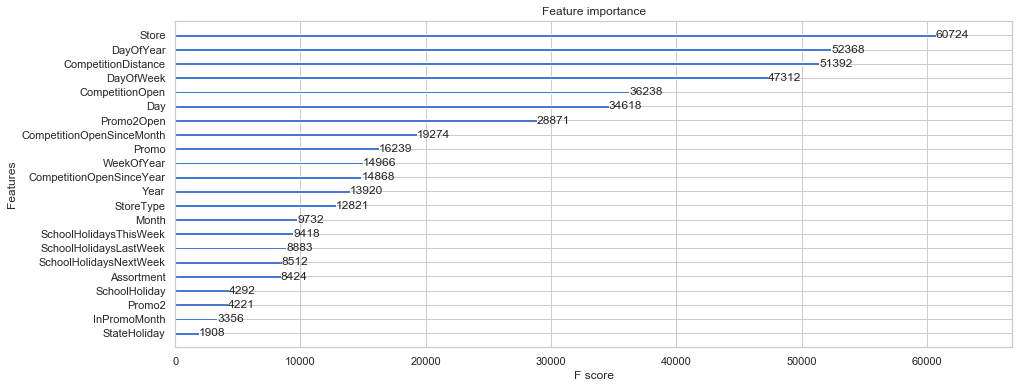

In [5]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

sns.set(style='whitegrid', palette='muted')

m.save_model('data/model.joblib.dat')

fig, ax = plt.subplots(figsize=(15, 6))
xgb.plot_importance(m.bst, ax=ax)
plt.show()

### 对测试集进行预测

In [ ]:
data_test = preprocessing.combine(data_test, data_store)
X_test = preprocessing.transform(data_test, dtype='test')
y_pred = m.predict(X_test[X_train.columns])
y_sub = pd.DataFrame(data=list(zip(range(1, y_pred.shape[0] + 1), y_pred)), columns=['Id', 'Sales'])
y_sub.to_csv('data/submission.csv', index=False)

### 可视化结果

In [ ]:
data_train_sales = pd.concat([X_train, y_train], axis=1)
data_train_sales['Date'] = pd.to_datetime(data_train_sales[['Year', 'Month', 'Day']])
data_train_sales = data_train_sales[(data_train_sales['Date'] >= '2014-08-01') & (data_train_sales['Date'] <= '2014-09-17')]
data_test_sales = pd.concat([X_test, pd.Series(y_pred, name='Sales')], axis=1)
data_test_sales['Date'] = pd.to_datetime(data_test_sales[['Year', 'Month', 'Day']])
data_train_sales_1 = data_train_sales.groupby(pd.Grouper(key='Date', freq='D')).mean()
data_test_sales_1 = data_test_sales.groupby(pd.Grouper(key='Date', freq='D')).mean()

plt.figure(figsize=(15, 3))
sns.lineplot(x=data_train_sales_1.index, y=data_train_sales_1['Sales']).set_title('Average daily sales per 7 days from 2014-08-01 to 2014-09-17')
plt.show()
plt.figure(figsize=(15, 3))
sns.lineplot(x=data_test_sales_1.index, y=data_test_sales_1['Sales']).set_title('Average daily sales per 7 days from 2015-08-01 to 2015-09-17')
plt.show()